In [158]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
import sys

In [160]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !pip install -U pyspellchecker -qq
    !python -m spacy download en_core_web_sm -qq
    !python -m spacy download en_core_web_lg -qq

    basepath = '/content/drive/MyDrive/data'
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/NLP UTD')
else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
    sys.path.append(
    '/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##  Importing Libraries

In [187]:
import numpy as np
import pandas as pd

In [336]:
from pathlib import Path

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from CustomPreprocessorSpacy import SpacyPreprocessor as preprocessor
from FeaturizerSpacy import ManualFeatures as featurize
from plot_learning_curve import *

from sklearn.base import TransformerMixin, BaseEstimator

from spellchecker import SpellChecker
from scipy.sparse import csr_matrix
import re, os

In [189]:
data_loc=Path(basepath)/"datasets"/"spam.csv"
spam_data = pd.read_csv(data_loc, encoding="ISO-8859-1")

In [190]:
spam_data.head(1)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN


In [191]:
spam_data.dropna(axis=1, inplace=True)

In [192]:
spam_data.shape

(5572, 2)

In [193]:
spam_data.rename(columns={"v1":"label","v2":"message"},inplace=True)

In [194]:
spam_data.head(1)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."


In [195]:
### Percentage of each label in the set which shows that around 86.6 percent of data is classified as ham.


(spam_data['label'].value_counts()/len(spam_data)) * 100

,count
label,
ham,86.593683
spam,13.406317


In [196]:
spam_data['label'].replace({"ham":0,"spam":1},inplace=True)

In [197]:
spam_data.head(3)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


Choice of Metric along with reasons.

---



What we have here is a heavily imbalaned dataset with category 0 with 87% values. For a spam detection problem, classifying a non-spam mail as spam can be problematic due to loss of an important mail due to our model. Though classifying a spam mail as non-spam is also a failure of the model but is still very less critical relying on the user's acumen to understand the mail's intention.

Hence we have to maximize our True Positive Rate. TPR. or F1-score to maintain a harmonic balance between both sets.

f1-weighted will be my choice as a metric.

## Sampling Data

In [198]:
spam_small = spam_data.sample(frac=0.07, replace=True, random_state=1)

In [199]:
(spam_small['label'].value_counts()/len(spam_small)) * 100

,count
label,
0,85.897436
1,14.102564


In [200]:
X_train = spam_small['message'].values
y_train = spam_small['label'].values

## Pipelines

 > The Model i'll be choosing to solve a Spam Detection issue is a Multinomial Naive Bayes Probabilistic Model because it works well with word frequency data and is much simplistic than my other choice, i.e XGBoost

#### Model

In [201]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

#### Randomized (Halved) Search for Hyperparams

In [202]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

#### Cross Validation

In [203]:
from sklearn.model_selection import StratifiedKFold
cv_kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

#### Stopwords

In [204]:
nlp = spacy.load('en_core_web_lg')
stopwords = nlp.Defaults.stop_words

### Pipeline 1 - Sparse Embeddings and Modelling

In [205]:
preprop = preprocessor(model='en_core_web_lg')
X_train_pipe1 = preprop.transform(X_train.copy())
y_train_pipe1 = y_train.copy()

/content/drive/MyDrive/Colab Notebooks/NLP UTD/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [206]:
X_train_pipe1[:5]

['k k sms chat',
 'print oh   < >   come upstairs',
 'huh not thk oredi page',
 'oh oh den muz change plan liao yan jiu',
 'hey charles sorry late reply']

In [207]:
pipeline_1 = Pipeline([('embedding', TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = 'english')),('classifier',MultinomialNB())])

In [208]:
param_grid_1 = {'embedding__max_features':[1000, 2000, 5000, 8000, 10000], 'classifier__alpha':[0.001, 0.01, 0.1, 0.5, 1.0]}

In [209]:
#f1-weighted, f1-macro, roc_auc, precision

random_search_1_clf = HalvingRandomSearchCV(estimator=pipeline_1, param_distributions = param_grid_1, cv=cv_kfold, scoring='f1_weighted', random_state=1)

In [210]:
random_search_1_clf.fit(X_train_pipe1, y_train_pipe1)

HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                      estimator=Pipeline(steps=[('embedding',
                                                 TfidfVectorizer(encoding='latin-1',
                                                                 stop_words='english',
                                                                 strip_accents='unicode')),
                                                ('classifier',
                                                 MultinomialNB())]),
                      param_distributions={'classifier__alpha': [0.001, 0.01,
                                                                 0.1, 0.5,
                                                                 1.0],
                                           'embedding__max_features': [1000,
                                                                       2000,
                                                                       5000,
                                                                       8000,
                                                                       10000]},
                      random_state=1, scoring='f1_weighted')

In [211]:
print(f'Best cross-validation score: {random_search_1_clf.best_score_:.2f}')
print("\nBest parameters: ", random_search_1_clf.best_params_)
print("\nBest estimator: ", random_search_1_clf.best_estimator_)

Best cross-validation score: 0.95

Best parameters:  {'embedding__max_features': 8000, 'classifier__alpha': 0.001}

Best estimator:  Pipeline(steps=[('embedding',
                 TfidfVectorizer(encoding='latin-1', max_features=8000,
                                 stop_words='english',
                                 strip_accents='unicode')),
                ('classifier', MultinomialNB(alpha=0.001))])


#### Plotting CV Results and how this pipeline has fared

---



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

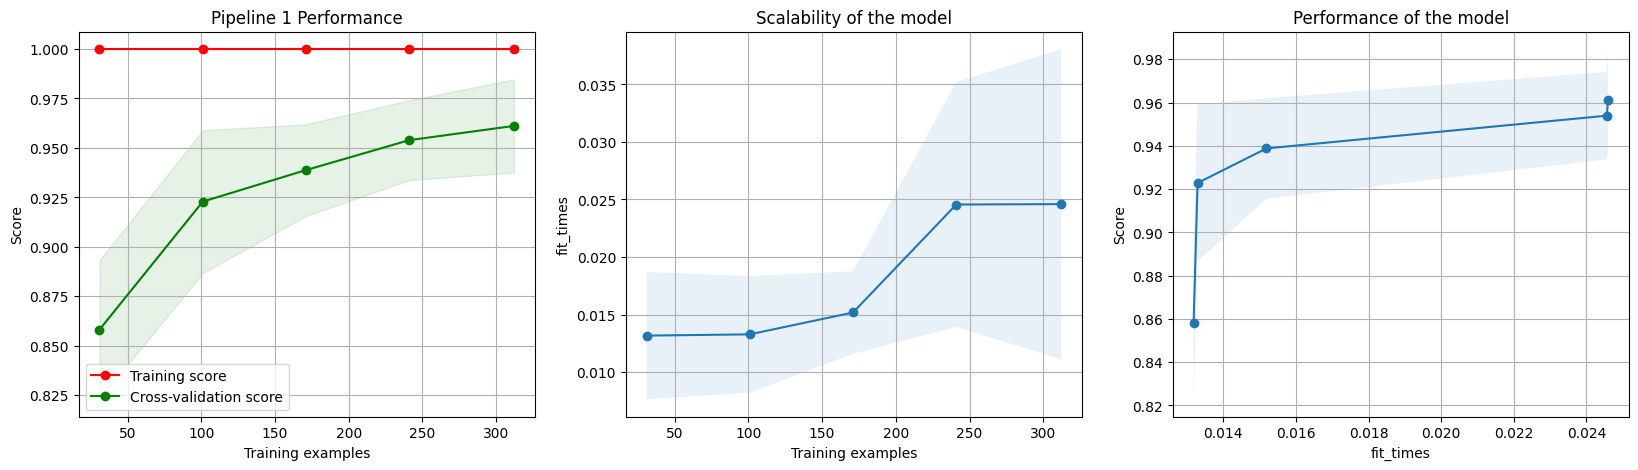

In [214]:
plot_learning_curve(estimator = random_search_1_clf.best_estimator_, title = 'Pipeline 1 Performance',X=X_train_pipe1, y=y_train_pipe1,cv=cv_kfold, scoring='f1_weighted')

### Insights - Pipeline 1

The Model is actually overfitting on a smaller set. Hence using this model to train on a bigger sample space might give good results.

### Pipeline 2 - Feature Engineering / Manual Feature Creation

In [216]:
preprop = preprocessor(model='en_core_web_lg', batch_size=500, basic_clean_only=True, lemmatize=False, lower=False, remove_stop=False, remove_punct=False, remove_email=False, remove_url=False, add_user_mention_prefix=False)
X_train_pipe2 = preprop.transform(X_train.copy())
y_train_pipe2 = y_train.copy()

/content/drive/MyDrive/Colab Notebooks/NLP UTD/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [236]:
featurize??

The features I understand should help identifying a spam

 - High count of URLs
 - High Spelling mistakes
 - Words that are all-caps and have unusual amount of exclamation marks and question marks.

In [225]:
### Lets create our own features based on the input analysis
mask = [y_train_pipe2 == 1]
np.where(mask)[True]

array([  6,  19,  31,  50,  54,  58,  64,  99, 105, 112, 120, 129, 131,
       145, 154, 158, 160, 162, 171, 172, 173, 181, 183, 184, 195, 196,
       211, 212, 216, 234, 239, 248, 250, 263, 265, 268, 274, 281, 286,
       291, 301, 305, 318, 320, 323, 325, 326, 327, 328, 330, 332, 333,
       350, 357, 370])

In [238]:
## We get this weird message as spam.
X_train_pipe2[31]

'Hey Boys. Want hot XXX pics sent direct 2 ur phone? Txt PORN to 69855, 24Hrs free and then just 50p per day. To stop text STOPBCM SF WC1N3XX'

In [243]:
X_train_pipe2[318]

'FREE entry into our å£250 weekly comp just send the word WIN to 80086 NOW. 18 T&C www.txttowin.co.uk'

In [304]:
class CustomFeatures(featurize):
  def __init__(self,spacy_model, batch_size = 64, pos_features = True, ner_features = True, text_descriptive_features = True, wrong_spelling_features = True, all_caps_and_characters=True, num_urls_feature = True):
    self.spacy_model = spacy_model
    self.batch_size = batch_size
    self.pos_features = pos_features
    self.ner_features = ner_features
    self.text_descriptive_features = text_descriptive_features
    self.wrong_spelling_features = wrong_spelling_features
    self.all_caps_and_characters = all_caps_and_characters
    self.num_urls_feature = num_urls_feature

  def spelling_errors(self, cleaned_text):

    list_count_spell_errors=[]
    spell = SpellChecker()

    for text in cleaned_text:
      mistakes = spell.unknown(text.split())
      list_count_spell_errors.append(len(mistakes))
    spelling_mistakes_features = np.vstack((list_count_spell_errors))
    return spelling_mistakes_features


  def all_caps_count(self, cleaned_text):

    list_all_caps = []
    list_excl_marks = []
    list_ques_marks = []


    for text in cleaned_text:
      all_caps_words = re.findall(r'\b[A-Z][A-Z]+\b', text)
      list_all_caps.append(len(all_caps_words))

      multiple_exclamation_marks = re.findall(r'!{3,}', text)
      list_excl_marks.append(len(multiple_exclamation_marks))

      multiple_question_marks = re.findall(r'\?{3,}', text)
      list_ques_marks.append(len(multiple_question_marks))

    unusual_text_features = np.vstack((list_all_caps,list_excl_marks,list_ques_marks))
    return np.transpose(unusual_text_features)

  def number_of_urls(self, cleaned_text):

    list_num_urls = []

    url_pattern = re.compile(
        r'(https?://[^\s/$.?#].[^\s]*|www\.[^\s/$.?#].[^\s]*)',
        re.IGNORECASE
    )

    for text in cleaned_text:
      urls = url_pattern.findall(text)
      list_num_urls.append(len(urls))

    url_features = np.vstack((list_num_urls))
    return url_features

  def transform(self, X, y=None):

        try:
            # Check if the input data is a list or numpy array
            if not isinstance(X, (list, np.ndarray)):
                raise TypeError(f"Expected list or numpy array, got {type(X)}")


            feature_names = []

            if self.text_descriptive_features:
                text_descriptive_features = self.get_text_descriptive_features(X)
                feature_names.extend(['count_words', 'count_characters',
                                      'count_characters_no_space', 'avg_word_length',
                                      'count_numbers', 'count_sentences'])
            else:
                text_descriptive_features = np.empty(shape=(0, 0))

            if self.pos_features:
                pos_features = self.get_pos_features(X)

                feature_names.extend(['noun_count', 'aux_count', 'verb_count', 'adj_count'])
            else:
                pos_features = np.empty(shape=(0, 0))

            if self.ner_features:
                ner_features = self.get_ner_features(X)

                feature_names.extend(['ner'])
            else:
                ner_features = np.empty(shape=(0, 0))

            if self.all_caps_and_characters:
              unusual_features = self.all_caps_count(X)
              feature_names.extend(['caps_count','excl_count','ques_count'])
            else:
              unusual_features = np.empty(shape=(0,0))

            if self.num_urls_feature:
              url_feature = self.number_of_urls(X)
              feature_names.extend(['urls_count'])
            else:
              url_feature = np.empty(shape=(0,0))

            if self.wrong_spelling_features:
              spelling_mistakes_features = self.spelling_errors(X)
              feature_names.extend(['spelling_errors_count'])
            else:
              spelling_mistakes_features = np.empty(shape=(0,0))

            # Stack the feature arrays horizontally to form a single 2D numpy array
            return np.hstack((text_descriptive_features, pos_features,  ner_features, unusual_features, url_feature, spelling_mistakes_features)), feature_names

        except Exception as error:
            print(f'An exception occured: {repr(error)}')

In [305]:
featurizer = CustomFeatures(spacy_model='en_core_web_lg', batch_size = 500)

In [306]:
X_train_features_pipe2, feature_names = featurizer.fit_transform(X_train_pipe2)

In [307]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_numbers',
 'count_sentences',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner',
 'caps_count',
 'excl_count',
 'ques_count',
 'urls_count',
 'spelling_errors_count']

In [308]:
pipeline_2 = Pipeline([
    ('classifier', MultinomialNB()),
])

In [309]:
param_grid_2 = {'classifier__alpha':[0.001, 0.01, 0.1, 0.5, 1.0]}

In [310]:
random_search_2_clf = HalvingRandomSearchCV(estimator=pipeline_2, param_distributions = param_grid_2, cv=cv_kfold, scoring='f1_weighted', random_state=1)

In [311]:
random_search_2_clf.fit(X_train_features_pipe2, y_train_pipe2)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=19. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                      estimator=Pipeline(steps=[('classifier',
                                                 MultinomialNB())]),
                      param_distributions={'classifier__alpha': [0.001, 0.01,
                                                                 0.1, 0.5,
                                                                 1.0]},
                      random_state=1, scoring='f1_weighted')

In [312]:
print(f'Best cross-validation score: {random_search_2_clf.best_score_:.2f}')
print("\nBest parameters: ", random_search_2_clf.best_params_)
print("\nBest estimator: ", random_search_2_clf.best_estimator_)

Best cross-validation score: 0.93

Best parameters:  {'classifier__alpha': 0.1}

Best estimator:  Pipeline(steps=[('classifier', MultinomialNB(alpha=0.1))])


#### Plotting CV Results and how this pipeline has fared

---



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

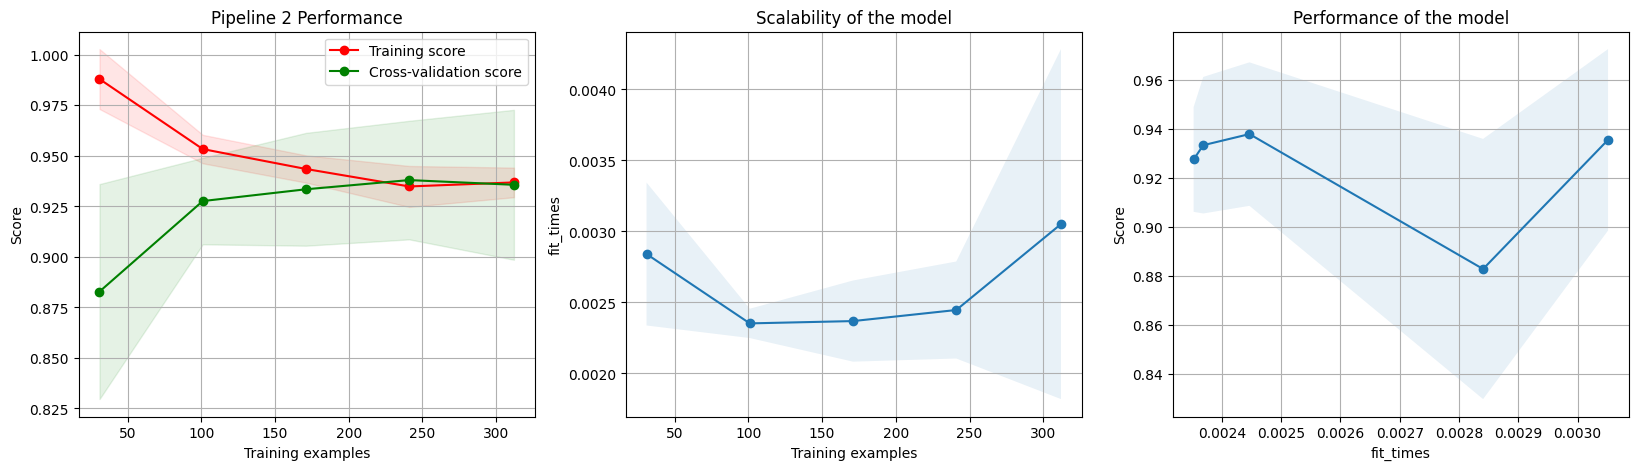

In [314]:
plot_learning_curve(estimator = random_search_2_clf.best_estimator_, title = 'Pipeline 2 Performance',X=X_train_features_pipe2, y=y_train_pipe2,cv=cv_kfold, scoring='f1_weighted')

#### Insights - Pipeline 2

> We can see as the training examples increase, our model initially overfits but even after just 100 examples, it starts to underfit hence increasing the fed data, it is only going to get worse.

> Still the performance on both training and cross-validation set is very noteworthy hence it might prove to be a decent model regardless.

## Pipeline 3 - Using both Manual Features and TFIDF Embeddings and ML Modelling

In [337]:
#Dataframe with only extracted features

X_train_pipe3 = pd.concat((pd.DataFrame(X_train_pipe2, columns=['text_c']),
                           pd.DataFrame(X_train_features_pipe2, columns=feature_names)), axis=1)

In [338]:
y_train_pipe3 = y_train.copy()

In [339]:
X_train_pipe3.head(1)

,text_c,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner,caps_count,excl_count,ques_count,urls_count,spelling_errors_count
0,K k:) sms chat with me.,6.0,23.0,18.0,2.571429,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [340]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [341]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(encoding='latin-1',stop_words='english',strip_accents='unicode')), ])

In [342]:
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'text_c'),
    ], remainder=sparse_features
)

In [343]:
pipeline_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', MultinomialNB()),
                         ])

In [344]:
param_grid_3 = {'combined_features__tfidf__tfidf__max_features': [1000, 2000, 5000, 8000, 10000],
                           'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0]
                           }

In [345]:
random_search_3_clf = HalvingRandomSearchCV(estimator=pipeline_3, param_distributions = param_grid_3, cv=cv_kfold, scoring='f1_weighted', random_state=1)

In [346]:
random_search_3_clf.fit(X_train_pipe3, y_train_pipe3)

HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                      estimator=Pipeline(steps=[('combined_features',
                                                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                              SparseTransformer())]),
                                                                   transformers=[('tfidf',
                                                                                  Pipeline(steps=[('tfidf',
                                                                                                   TfidfVectorizer(encoding='latin-1',
                                                                                                                   stop_words='english',
                                                                                                                   strip_accents='unicode'))]),
                                                                                  'text_c')])),
                                                ('classifier',
                                                 MultinomialNB())]),
                      param_distributions={'classifier__alpha': [0.001, 0.01,
                                                                 0.1, 0.5,
                                                                 1.0],
                                           'combined_features__tfidf__tfidf__max_features': [1000,
                                                                                             2000,
                                                                                             5000,
                                                                                             8000,
                                                                                             10000]},
                      random_state=1, scoring='f1_weighted')

In [347]:
print(f'Best cross-validation score: {random_search_3_clf.best_score_:.2f}')
print("\nBest parameters: ", random_search_3_clf.best_params_)
print("\nBest estimator: ", random_search_3_clf.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'combined_features__tfidf__tfidf__max_features': 2000, 'classifier__alpha': 0.01}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(encoding='latin-1',
                                                                                   max_features=2000,
                                                                                   stop_words='english',
                                                                                   strip_accents='unicode'))]),
                                                  'text_c')])),
                ('classifier'

#### Plotting CV Results and how this pipeline has fared

---






<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

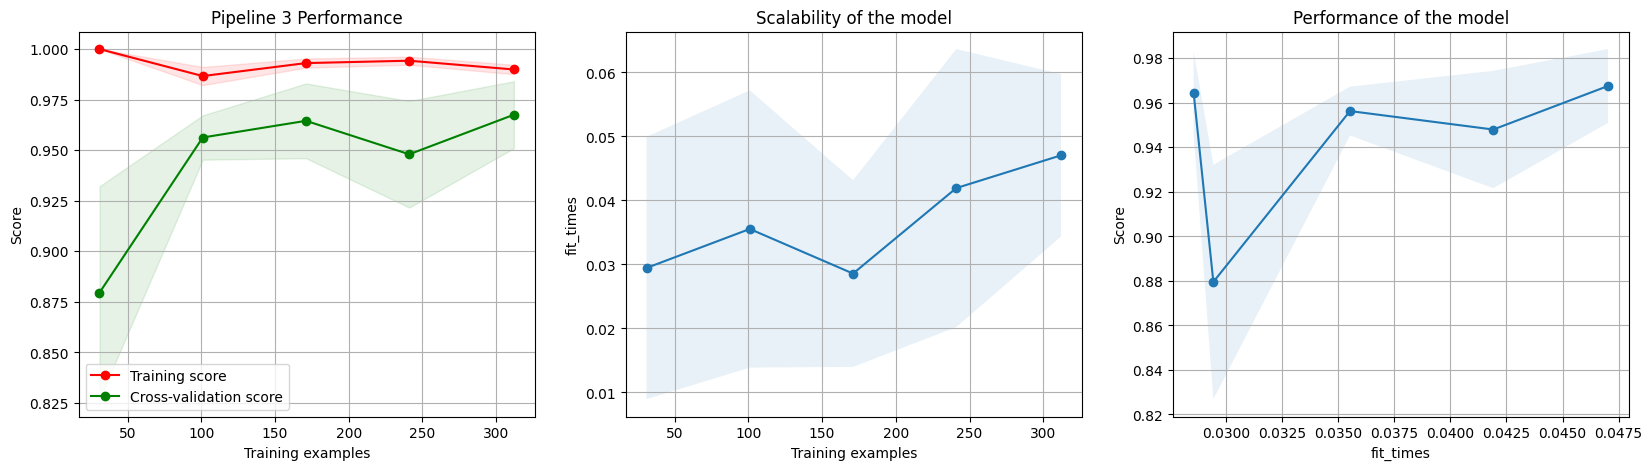

In [348]:
plot_learning_curve(estimator = random_search_3_clf.best_estimator_, title = 'Pipeline 3 Performance',X=X_train_pipe3, y=y_train_pipe3,cv=cv_kfold, scoring='f1_weighted')

#### Insights - Pipeline 3

> We can see that the model overfits the data not at as extent of the Pipeline 1 but highly significant.

> With an impressive CV score of 97% f1-weighted score, this will be my go-to model for the classifications on a larger dataset.

> With 2000 features, it is also a simpler model as compared to our second choice Model 1 with 8000 features (Occam's Razor)